# EmoRecSys - CF

[EmoRecSys Survey](https://emorecsys.pt/)

###### Imports

In [1]:
# ---- INSTALLATIONS ---- #
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357224 sha256=7f43039adb784633d2b892e5d447d07aaed5e547b4b9833257e4c483672fd2df
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [2]:
# ---- IMPORTS ---- #
from surprise import Reader, Dataset, CoClustering, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, NMF
from ipywidgets import HBox, VBox, Image as WidgetImage
from sklearn.model_selection import ParameterGrid
from collections import defaultdict
from IPython.display import display
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
import pandas as pd
import numpy as np
import surprise
import random



drive.mount('/content/drive')

Mounted at /content/drive


## 1. Exploratory Data Analysis (EDA)

In [3]:
dataset_cf = pd.read_csv("/content/drive/MyDrive/THESIS/EmoRecSys/CSVs/ratings.csv")
dataset_cf.head()

,id,id_photo,id_survey,like_bool,anger,fear,disgust,sadness,happiness,surprise,neutral,valence,arousal,dominance
0,1,1754,1,1,0,0,0,0,0,0,5,3,1,2
1,2,1785,1,1,0,0,0,2,0,0,0,2,2,3
2,3,123,1,0,0,0,0,4,0,0,0,1,3,1
3,4,2315,1,0,0,0,0,2,0,0,0,2,1,3
4,5,1548,1,0,0,0,0,0,0,0,5,3,1,3


In [4]:
dataset_cf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2445 entries, 0 to 2444
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         2445 non-null   int64
 1   id_photo   2445 non-null   int64
 2   id_survey  2445 non-null   int64
 3   like_bool  2445 non-null   int64
 4   anger      2445 non-null   int64
 5   fear       2445 non-null   int64
 6   disgust    2445 non-null   int64
 7   sadness    2445 non-null   int64
 8   happiness  2445 non-null   int64
 9   surprise   2445 non-null   int64
 10  neutral    2445 non-null   int64
 11  valence    2445 non-null   int64
 12  arousal    2445 non-null   int64
 13  dominance  2445 non-null   int64
dtypes: int64(14)
memory usage: 267.5 KB


In [5]:
dataset_cf.describe()

,id,id_photo,id_survey,like_bool,anger,fear,disgust,sadness,happiness,surprise,neutral,valence,arousal,dominance
count,2445.000000,2445.000000,2445.000000,2445.000000,2445.000000,2445.000000,2445.000000,2445.000000,2445.000000,2445.000000,2445.000000,2445.000000,2445.000000,2445.000000
mean,1223.000000,1540.308384,82.000000,0.680982,0.188139,0.497342,0.276892,0.709611,1.480982,0.541922,1.044172,3.062577,2.387321,2.613906
std,705.955027,887.328837,47.062787,0.466192,0.732531,1.185916,0.909476,1.435724,1.932406,1.213494,1.674546,1.222977,1.207960,1.223663
min,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,612.000000,738.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000
50%,1223.000000,1594.000000,82.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,3.000000
75%,1834.000000,2302.000000,123.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,2.000000,4.000000,3.000000,3.000000
max,2445.000000,3068.000000,163.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [6]:
dataset_cf.isnull().sum()

id           0
id_photo     0
id_survey    0
like_bool    0
anger        0
fear         0
disgust      0
sadness      0
happiness    0
surprise     0
neutral      0
valence      0
arousal      0
dominance    0
dtype: int64

In [7]:
dataset_cf.nunique()

id           2445
id_photo      553
id_survey     163
like_bool       2
anger           6
fear            6
disgust         6
sadness         6
happiness       6
surprise        6
neutral         6
valence         5
arousal         5
dominance       5
dtype: int64

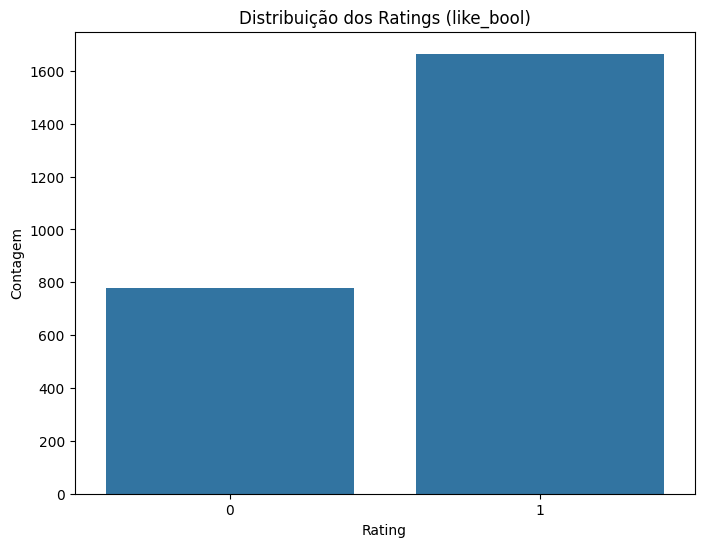

In [8]:
# Distribuição dos ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='like_bool', data=dataset_cf)
plt.title('Distribuição dos Ratings (like_bool)')
plt.xlabel('Rating')
plt.ylabel('Contagem')
plt.show()


In [9]:
user_interactions = dataset_cf['id_survey'].value_counts()
item_interactions = dataset_cf['id_photo'].value_counts()

print("Número médio de interações por usuário:", user_interactions.mean())
print("Número médio de interações por item:", item_interactions.mean())
print("Número mínimo de interações por usuário:", user_interactions.min())
print("Número mínimo de interações por item:", item_interactions.min())

Número médio de interações por usuário: 15.0
Número médio de interações por item: 4.421338155515371
Número mínimo de interações por usuário: 15
Número mínimo de interações por item: 1


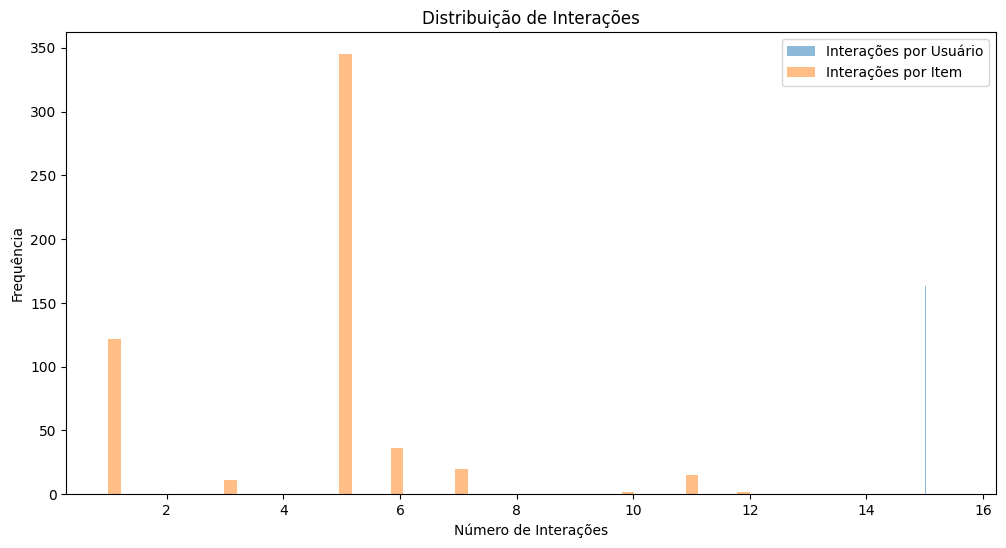

In [10]:
plt.figure(figsize=(12, 6))
plt.hist(user_interactions, bins=50, alpha=0.5, label='Interações por Usuário')
plt.hist(item_interactions, bins=50, alpha=0.5, label='Interações por Item')
plt.legend(loc='upper right')
plt.xlabel('Número de Interações')
plt.ylabel('Frequência')
plt.title('Distribuição de Interações')
plt.show()

## 2. Preprocessing

In [11]:
def check_items(trainset, testset):
  trainset_items = set(list(item for _, item, _ in trainset))
  testset_items = set(list(item for _, item, _ in testset))

  items_unknown = list(testset_items - trainset_items)

  return len(items_unknown) == 0

def split_emorecsys(dataset, train=0.8, test=0.2):
  trainset, testset = list(), list()

  items_ratings = dataset.groupby('id_photo').size().to_dict() # get number of rating for each id_photo
  items_one_rating = [id_photo for id_photo, size in items_ratings.items() if size == 1] # get the ones with only 1 rating
  # print(items_one_rating)


  for user in list(set(dataset['id_survey'])):
    user_ratings = dataset[dataset['id_survey'] == user]
    all_ratings = list((user, id_photo, like_bool) for id_photo, like_bool in zip(user_ratings['id_photo'], user_ratings['like_bool']))
    size_ratings = len(all_ratings)

    user_trainset = list(rating for rating in all_ratings if rating[1] in items_one_rating) # start trainset with items with only one rating

    relevant = list(x for x in all_ratings if x[2] == 1)
    if relevant: # making sure that we have at least one relevant rating in the testset
      new_rating = random.sample(relevant, 1)
      user_testset = new_rating if new_rating[0] not in user_trainset else list()
    else:
      raise ValueError('The user ' + str(user) + ' did not liked any photo')

    while len(user_testset) < size_ratings*test: # add random ratings until fullfil the size of testset
      new_rating = random.choice(all_ratings)
      if new_rating not in user_testset and new_rating not in user_trainset:
        user_testset.append(new_rating)

    # adding remaining ratings to trainset
    user_trainset.extend(new_rating for new_rating in all_ratings if new_rating not in user_testset and new_rating not in user_trainset)

    assert len(user_trainset) == size_ratings*train
    assert len(user_testset) == size_ratings*test

    # print(user_trainset)
    # print(user_testset)

    trainset.extend(user_trainset)
    testset.extend(user_testset)

  if check_items(trainset, testset):
    train_df = pd.DataFrame(trainset, columns=['id_survey', 'id_photo', 'like_bool']) # like_bool
  else:
    return split_emorecsys(dataset, train, test)

  reader = Reader(rating_scale=(0,1)) # like_bool
  surprise_train = Dataset.load_from_df(train_df, reader).build_full_trainset()

  return surprise_train, testset

## 3. Modelling and Evaluating

In [12]:
models_grid = {'KNN': {'k': [10, 20, 30],
                       'min_k': [1, 2, 3],
                       'sim_options': [{'name': 'pearson', 'user_based': False},
                                       {'name': 'pearson', 'user_based': True},
                                       {'name': 'msd', 'user_based': False},
                                       {'name': 'msd', 'user_based': True}],
                       'verbose': [False]},

               'SVD': {'n_factors': [10, 50, 100],
                       'n_epochs': [20, 40, 60],
                       'lr_all': [0.005, 0.01, 0.02],
                       'reg_all': [0.05, 0.1 , 0.2]},

               'NMF': {'n_factors': [10, 50, 100],
                       'n_epochs': [20, 40, 60],
                       'reg_pu': [0.001, 0.005, 0.01],
                       'reg_qi': [0.01, 0.05, 0.1]},

               'CoClustering': {'n_cltr_u': np.arange(10, 101, 10),  # number of user clusters
                                'n_cltr_i': np.arange(10, 201, 10),  # number of item clusters
                                'n_epochs': np.arange(10, 51, 10)}} # number of epochs

##### Evaluation Functions


- vamos prever os itens do `testset` + x = 20, sendo x são items que o user AINDA NÃO VIU
- os items relevantes serão os que estão presentes no testset E TEM SCORE 1 (gostaram -- porque estamos a usar o like_bool)
  - para cada user, as previsões são ordenadas DESC com base no rating estimado `est`
  - depois as previsões são filtradas para manter apenas aquelas com `est` >= threshold (0.5), e serão essas as recomendações (até k).

In [18]:
def get_to_predict(user, trainset, testset):
  " Generates a list of items for prediction, adding randomly items user has not seen"

  # get the items from the testset for given user
  items_testset = list((uid, iid) for uid, iid, _ in testset if uid == user)
  items_seen_by_user = {trainset.to_raw_iid(iid) for (uid, iid, _) in trainset.all_ratings() if trainset.to_raw_uid(uid) == user}
  all_items = {trainset.to_raw_iid(iid) for (_, iid, _) in trainset.all_ratings()}

  # find items user has not seen, and randomly sample 20 unseen items
  items_unseen_by_user = list(all_items - items_seen_by_user)
  unseen_sample = random.sample(items_unseen_by_user, 20)

  existing_iids = [iid for _, iid in items_testset]
  for item in unseen_sample:
    # add item if its not already in the list for prediction, while there's less than 20 items
    if (item not in existing_iids) and (len(items_testset) < 20):
      items_testset.append((user, item))
      existing_iids.append(item)

  # print(f'User {user} - Items to predict: {items_testset}')
  return items_testset

def precision_recall_at_k(model, trainset, testset, k=10, threshold=0):
  precisions, recalls, f1scores = dict(), dict(), dict()
  # get list of users in testset
  test_users = list(set(item[0] for item in testset))

  for user in test_users:
    # generate items to predict for given user
    to_predict = get_to_predict(user, trainset, testset)
    predictions = [model.predict(uid, iid) for (uid, iid) in to_predict]
    # print(predictions)
    # print(f'Prediction for user {user}: {predictions}')

    ratings = [(iid, est) for (_, iid, _, est, _) in predictions if est >= threshold] # only recommend when est >= threshold
    ratings.sort(key=lambda x: x[1], reverse=True) # descending sort

    # relevant items in the testset need to have a true_rating > 0
    items_relevant = list(item[1] for item in testset if item[0] == user and item[2] > 0) # like_bool

    # print("USER", user)
    # print("ITENS RELEVANTES:", items_relevant)
    # for i in range(k):
    #   print(f"K = {i+1} - ", ratings[:i+1])
    # print()

    rel = len(items_relevant) # total number of relevant items to the user
    rel_rec = sum(np.isin(iid, items_relevant) for iid, _ in ratings[:k]) # number of relevant items recommended to the user

    precisions[user] = rel_rec / k # number of relevant items recommended to the user / total number of recommended items to the user
    recalls[user] = rel_rec / rel if rel != 0 else 1 # number of relevant items recommended to the user / total number of relevant items to the user
    f1scores[user] = (2*precisions[user]*recalls[user]) / (precisions[user]+recalls[user]) if (precisions[user]+recalls[user]) != 0 else 0.0

  return precisions, recalls, f1scores

def evaluation(model, trainset, testset, k=10):
  precisions, recalls, f1scores = [], [], []

  # for k in range(k, k+1):
  for k in range(1, k+1):
    # precision_k, recall_k, f1score_k = precision_recall_at_k(predictions, testset, k, threshold=0)
    precision_k, recall_k, f1score_k = precision_recall_at_k(model, trainset, testset, k, threshold=0.5) # like_bool

    precision = np.mean(list(precision_k.values())) # average value of precision score of all users at top k
    recall = np.mean(list(recall_k.values())) # average value of recall score of all users at top k
    f1score = np.mean(list(f1score_k.values())) # f1score of all users at top k

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1score)

    # print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1score}')

  return precisions, recalls, f1scores

def avg_metrics(precisions, recalls, f1scores, k):
  precisions_avg, recall_avg, f1score_avg = [], [], []

  # for i in range(1):
  for i in range(k):
    precision = list(prec[i] for prec in precisions)
    recall = list(rec[i] for rec in recalls)
    f1score = list(f1[i] for f1 in f1scores)

    precisions_avg.append(np.round(np.mean(precision), 4))
    recall_avg.append(np.round(np.mean(recall), 4))
    f1score_avg.append(np.round(np.mean(f1score), 4))

  return precisions_avg, recall_avg, f1score_avg

def gridsearch_recommendation(model, param_grid, dataset, k=10):
  best_score = -1
  best_params = None

  for params in list(ParameterGrid(param_grid)):
    precisions_final, recalls_final, f1scores_final = [], [], []
    for i in range(5):
      trainset, testset = split_emorecsys(dataset)

      algo = model(**params)
      algo.fit(trainset)

      precisions, recalls, f1scores = evaluation(algo, trainset, testset, k=k)

      precisions_final.append(precisions)
      recalls_final.append(recalls)
      f1scores_final.append(f1scores)

    precision_avg, recall_avg, f1score_avg = avg_metrics(precisions_final, recalls_final, f1scores_final, k)

    # print(f'Parameters: {params}')
    # print()
    # print(f'Precisions: {precision_avg}, Recalls: {recall_avg}, F1 Scores: {f1score_avg}')

    # using f1score (k = 10) to select the best model as it is a harmonious average of precision and recall @ k
    if f1score_avg[-1] > best_score:
      best_score = f1score_avg[-1]
      best_params = params

      # keeping the precision, recall and f1score values for the best model
      best_precisions, best_recalls, best_f1scores = precision_avg, recall_avg, f1score_avg

  print(f'Best parameters: {best_params}')
  print(f'Best F1 Score: {best_score}\n')

  for i in range(k):
    print(f"K = {i+1} - Precision: {best_precisions[i]}, Recall: {best_recalls[i]}, F1 Score: {best_f1scores[i]}")

### 3.1. SVD

In [ ]:
gridsearch_recommendation(SVD, models_grid['SVD'], dataset_cf, k=10)

Best parameters: {'lr_all': 0.01, 'n_epochs': 20, 'n_factors': 10, 'reg_all': 0.05}
Best F1 Score: 0.2344

K = 1 - Precision: 0.2466, Recall: 0.1055, F1 Score: 0.1442
K = 2 - Precision: 0.2123, Recall: 0.18, F1 Score: 0.1894
K = 3 - Precision: 0.1975, Recall: 0.2571, F1 Score: 0.2172
K = 4 - Precision: 0.1837, Recall: 0.3249, F1 Score: 0.2284
K = 5 - Precision: 0.1806, Recall: 0.4006, F1 Score: 0.2427
K = 6 - Precision: 0.1779, Recall: 0.4699, F1 Score: 0.2524
K = 7 - Precision: 0.1637, Recall: 0.5055, F1 Score: 0.2421
K = 8 - Precision: 0.1613, Recall: 0.565, F1 Score: 0.2463
K = 9 - Precision: 0.1506, Recall: 0.5902, F1 Score: 0.236
K = 10 - Precision: 0.1464, Recall: 0.6393, F1 Score: 0.2344


### 3.2. NMF

In [ ]:
gridsearch_recommendation(NMF, models_grid['NMF'], dataset_cf, k=10)

Best parameters: {'n_epochs': 20, 'n_factors': 100, 'reg_pu': 0.001, 'reg_qi': 0.01}
Best F1 Score: 0.3466

K = 1 - Precision: 0.9718, Recall: 0.4728, F1 Score: 0.6117
K = 2 - Precision: 0.8245, Recall: 0.7374, F1 Score: 0.7538
K = 3 - Precision: 0.7223, Recall: 0.9331, F1 Score: 0.7929
K = 4 - Precision: 0.5417, Recall: 0.9331, F1 Score: 0.6689
K = 5 - Precision: 0.4334, Recall: 0.9331, F1 Score: 0.5788
K = 6 - Precision: 0.3611, Recall: 0.9331, F1 Score: 0.5102
K = 7 - Precision: 0.3096, Recall: 0.9331, F1 Score: 0.4562
K = 8 - Precision: 0.271, Recall: 0.9344, F1 Score: 0.4129
K = 9 - Precision: 0.2409, Recall: 0.9344, F1 Score: 0.3769
K = 10 - Precision: 0.2168, Recall: 0.9344, F1 Score: 0.3466


### 3.3. Co-Clustering

In [ ]:
gridsearch_recommendation(CoClustering, models_grid['CoClustering'], dataset_cf, k=10)

Best parameters: {'n_cltr_i': 10, 'n_cltr_u': 100, 'n_epochs': 30}
Best F1 Score: 0.2544

K = 1 - Precision: 0.584, Recall: 0.2685, F1 Score: 0.354
K = 2 - Precision: 0.4933, Recall: 0.4348, F1 Score: 0.4469
K = 3 - Precision: 0.3853, Recall: 0.5033, F1 Score: 0.4236
K = 4 - Precision: 0.3233, Recall: 0.5667, F1 Score: 0.4006
K = 5 - Precision: 0.2724, Recall: 0.5971, F1 Score: 0.3648
K = 6 - Precision: 0.2421, Recall: 0.6387, F1 Score: 0.3433
K = 7 - Precision: 0.2121, Recall: 0.6528, F1 Score: 0.3136
K = 8 - Precision: 0.1899, Recall: 0.6683, F1 Score: 0.2901
K = 9 - Precision: 0.1725, Recall: 0.6853, F1 Score: 0.2707
K = 10 - Precision: 0.1587, Recall: 0.7014, F1 Score: 0.2544


### 3.4. KNNBasic ("Not enough Neighbours")

In [ ]:
gridsearch_recommendation(KNNBasic, models_grid['KNN'], dataset_cf, k=10)

Best parameters: {'k': 20, 'min_k': 3, 'sim_options': {'name': 'pearson', 'user_based': False}, 'verbose': False}
Best F1 Score: 0.3532

K = 1 - Precision: 0.9399, Recall: 0.454, F1 Score: 0.5883
K = 2 - Precision: 0.8172, Recall: 0.7307, F1 Score: 0.7463
K = 3 - Precision: 0.7366, Recall: 0.9489, F1 Score: 0.8074
K = 4 - Precision: 0.5528, Recall: 0.9493, F1 Score: 0.6817
K = 5 - Precision: 0.4422, Recall: 0.9493, F1 Score: 0.5899
K = 6 - Precision: 0.3685, Recall: 0.9493, F1 Score: 0.5201
K = 7 - Precision: 0.3159, Recall: 0.9493, F1 Score: 0.4651
K = 8 - Precision: 0.2764, Recall: 0.9493, F1 Score: 0.4207
K = 9 - Precision: 0.2457, Recall: 0.9493, F1 Score: 0.384
K = 10 - Precision: 0.2211, Recall: 0.9493, F1 Score: 0.3532


### 3.5. KNNWithMeans

In [ ]:
gridsearch_recommendation(KNNWithMeans, models_grid['KNN'], dataset_cf, k=10)

Best parameters: {'k': 30, 'min_k': 3, 'sim_options': {'name': 'pearson', 'user_based': True}, 'verbose': False}
Best F1 Score: 0.3138

K = 1 - Precision: 0.8368, Recall: 0.3892, F1 Score: 0.5133
K = 2 - Precision: 0.7399, Recall: 0.6448, F1 Score: 0.6695
K = 3 - Precision: 0.6569, Recall: 0.8258, F1 Score: 0.7144
K = 4 - Precision: 0.4926, Recall: 0.8258, F1 Score: 0.6036
K = 5 - Precision: 0.3941, Recall: 0.8258, F1 Score: 0.5229
K = 6 - Precision: 0.3284, Recall: 0.8258, F1 Score: 0.4613
K = 7 - Precision: 0.2815, Recall: 0.8258, F1 Score: 0.4127
K = 8 - Precision: 0.2463, Recall: 0.8258, F1 Score: 0.3735
K = 9 - Precision: 0.219, Recall: 0.8258, F1 Score: 0.3411
K = 10 - Precision: 0.1971, Recall: 0.8258, F1 Score: 0.3138


In [ ]:
gridsearch_recommendation(KNNWithMeans, models_grid['KNN'], dataset_cf, k=10)

[Prediction(uid=1, iid=1059, r_ui=None, est=1, details={'actual_k': 0, 'was_impossible': False}), Prediction(uid=1, iid=2315, r_ui=None, est=0.6666666666666666, details={'actual_k': 0, 'was_impossible': False}), Prediction(uid=1, iid=948, r_ui=None, est=0.75, details={'actual_k': 0, 'was_impossible': False}), Prediction(uid=1, iid=559, r_ui=None, est=1, details={'actual_k': 0, 'was_impossible': False}), Prediction(uid=1, iid=567, r_ui=None, est=1, details={'actual_k': 0, 'was_impossible': False}), Prediction(uid=1, iid=1223, r_ui=None, est=1, details={'actual_k': 0, 'was_impossible': False}), Prediction(uid=1, iid=524, r_ui=None, est=0.6666666666666666, details={'actual_k': 0, 'was_impossible': False}), Prediction(uid=1, iid=1500, r_ui=None, est=0.3333333333333333, details={'actual_k': 0, 'was_impossible': False}), Prediction(uid=1, iid=230, r_ui=None, est=1, details={'actual_k': 0, 'was_impossible': False}), Prediction(uid=1, iid=2723, r_ui=None, est=0.8, details={'actual_k': 0, 'was_

KeyboardInterrupt: 

### 3.6. KNNWithZScore

In [ ]:
gridsearch_recommendation(KNNWithZScore, models_grid['KNN'], dataset_cf, k=10)

Best parameters: {'k': 10, 'min_k': 3, 'sim_options': {'name': 'pearson', 'user_based': True}, 'verbose': False}
Best F1 Score: 0.3051

K = 1 - Precision: 0.8307, Recall: 0.3869, F1 Score: 0.5104
K = 2 - Precision: 0.7166, Recall: 0.6207, F1 Score: 0.6464
K = 3 - Precision: 0.6389, Recall: 0.8027, F1 Score: 0.6944
K = 4 - Precision: 0.4791, Recall: 0.8027, F1 Score: 0.5868
K = 5 - Precision: 0.3833, Recall: 0.8027, F1 Score: 0.5083
K = 6 - Precision: 0.3194, Recall: 0.8027, F1 Score: 0.4485
K = 7 - Precision: 0.2738, Recall: 0.8027, F1 Score: 0.4013
K = 8 - Precision: 0.2396, Recall: 0.8027, F1 Score: 0.3631
K = 9 - Precision: 0.213, Recall: 0.8027, F1 Score: 0.3316
K = 10 - Precision: 0.1917, Recall: 0.8027, F1 Score: 0.3051


### 3.7. KNNBaseline

In [ ]:
gridsearch_recommendation(KNNBaseline, models_grid['KNN'], dataset_cf, k=10)

Best parameters: {'k': 10, 'min_k': 1, 'sim_options': {'name': 'pearson', 'user_based': True}, 'verbose': False}
Best F1 Score: 0.2475

K = 1 - Precision: 0.5779, Recall: 0.2734, F1 Score: 0.3573
K = 2 - Precision: 0.4577, Recall: 0.4164, F1 Score: 0.422
K = 3 - Precision: 0.3542, Recall: 0.4732, F1 Score: 0.3938
K = 4 - Precision: 0.2893, Recall: 0.5174, F1 Score: 0.3616
K = 5 - Precision: 0.2464, Recall: 0.5511, F1 Score: 0.3325
K = 6 - Precision: 0.2207, Recall: 0.5871, F1 Score: 0.314
K = 7 - Precision: 0.1984, Recall: 0.6174, F1 Score: 0.2944
K = 8 - Precision: 0.1787, Recall: 0.6346, F1 Score: 0.2738
K = 9 - Precision: 0.1651, Recall: 0.6558, F1 Score: 0.2595
K = 10 - Precision: 0.1541, Recall: 0.6816, F1 Score: 0.2475


## 4. Recommending

In [20]:
dataset_photos = pd.read_csv("/content/drive/MyDrive/THESIS/EmoRecSys/CSVs/photos.csv")
dataset_photos.set_index('id', inplace=True)

In [ ]:
def display_image(show_list, n_show=3):
  relevant_images_widgets = []
  for item in show_list:
    image = dataset_photos.loc[item]['file_name']
    ext = dataset_photos.loc[item]['ext']
    image_path = f'/content/drive/MyDrive/THESIS/EmoRecSys/emorecsys_survey_photos/{image}.{ext}'

    with open(image_path, "rb") as file:
      img = file.read()

    img_widget = WidgetImage(value=img, format='jpg', width=200, height=200)
    relevant_images_widgets.append(img_widget)

  display(VBox([HBox(relevant_images_widgets[i:i+n_show]) for i in range(0, len(relevant_images_widgets), n_show)]))

In [ ]:
def recommending_cf(model, params, dataset):
  trainset, testset = split_emorecsys(dataset)

  test_users = list(set(item[0] for item in testset))
  user = random.choice(test_users)
  items_relevant = list(item[1] for item in testset if item[0] == user and item[2] > 0)

  print('RELEVANT IMAGES:')
  display_image(items_relevant, len(items_relevant))

  algo = model(**params)
  algo.fit(trainset)

  to_predict = get_to_predict(user, trainset, testset)
  predictions = [algo.predict(uid, iid) for (uid, iid) in to_predict]

  ratings = [(iid, est) for (_, iid, _, est, _) in predictions if est >= 0.5]
  ratings.sort(key=lambda x: x[1], reverse=True)

  print('TOP 5 IMAGES RECOMMENDED:')
  ratings_5 = list(iid for iid, _ in ratings[:5])
  display_image(ratings_5, 5)

In [ ]:
recommending_cf(model=NMF, params={'n_epochs': 20, 'n_factors': 100, 'reg_pu': 0.001, 'reg_qi': 0.01}, dataset=dataset_cf)

RELEVANT IMAGES:


TOP 5 IMAGES RECOMMENDED:
